# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^3, < Delta_tau > = 2pi, K = 3
# eta M^2 = 0.0125

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

## Physical Parameters

In [4]:
# eta * Ma ^2 = 0.0125
Ma = 0.0125 ** (1/2)
K = 3
eta = 1

## Functions of Ma

In [5]:
meandeltaT = 2 * np.pi

# variables for generating F2 and G1
stdF2 = eta * Ma**2
limitY2 = eta 

## Calculation parameters

In [6]:
L = 1
M = 10**3
M_short = 200
N = 1
m = 10**2

J = 300
dTau = 2 * np.pi / J

Tr = K * meandeltaT

## Initial Conditions

In [7]:
initial_AT = 0
initial_dAdT = 0

## Evolution 1

In [8]:
# deltaT is the length of each eddy turnover
deltaT = fundeltaT(n_bins, M, dTau)

# Tturb is the consecutive sum of deltaT's so each value marks a new eddy
Tturb = funTturb(deltaT)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


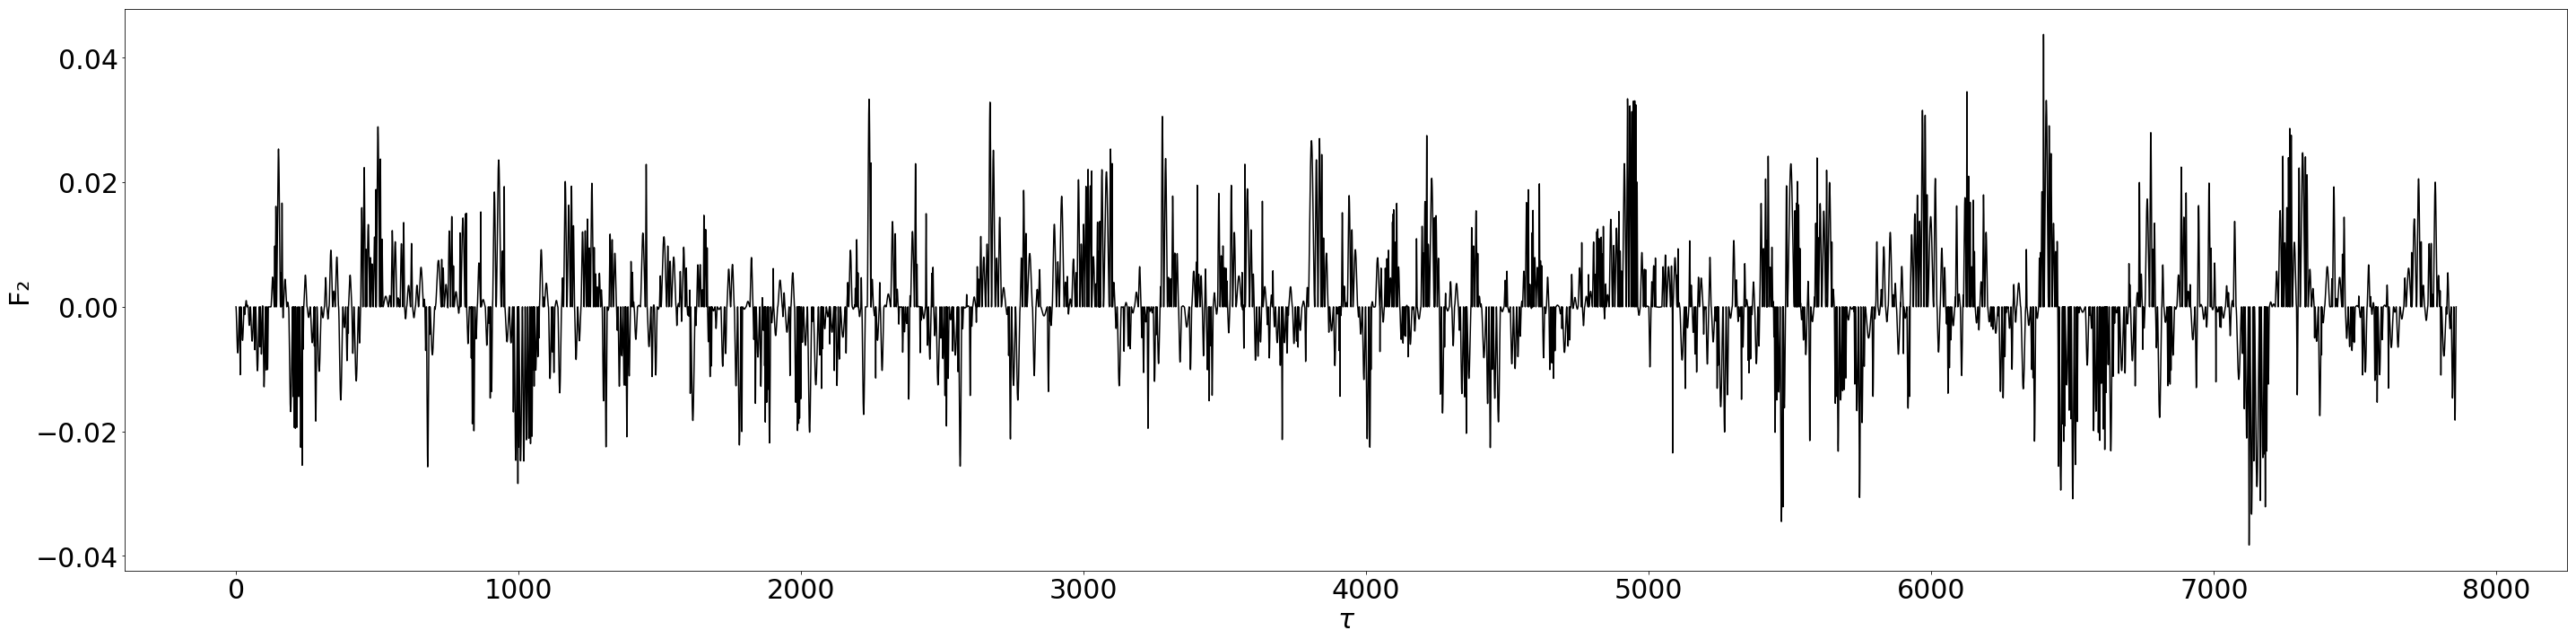

In [18]:
F2, time = funF_k(stdF2, limitY2, deltaT, Tturb)

Funplots(time, F2)

In [20]:
ReF2 = []
ImF2 = []

# w_0 ReF2 = int F2(T)cos(qT) dT
# w_0 ImF2 = int F2(T)sin(qT) dT

# q = w / w0
# 0.1 <= q <= 10

for q in np.arange(0.1, 10, 0.1):
    totalRe = 0
    totalIm = 0
    for i in range(len(time)):
        totalRe += F2[i] * math.cos(q*time[i]) * time[i]
        totalIm += F2[i] * math.sin(q*time[i]) * time[i]
    ReF2.append(totalRe)
    ImF2.append(totalIm) 

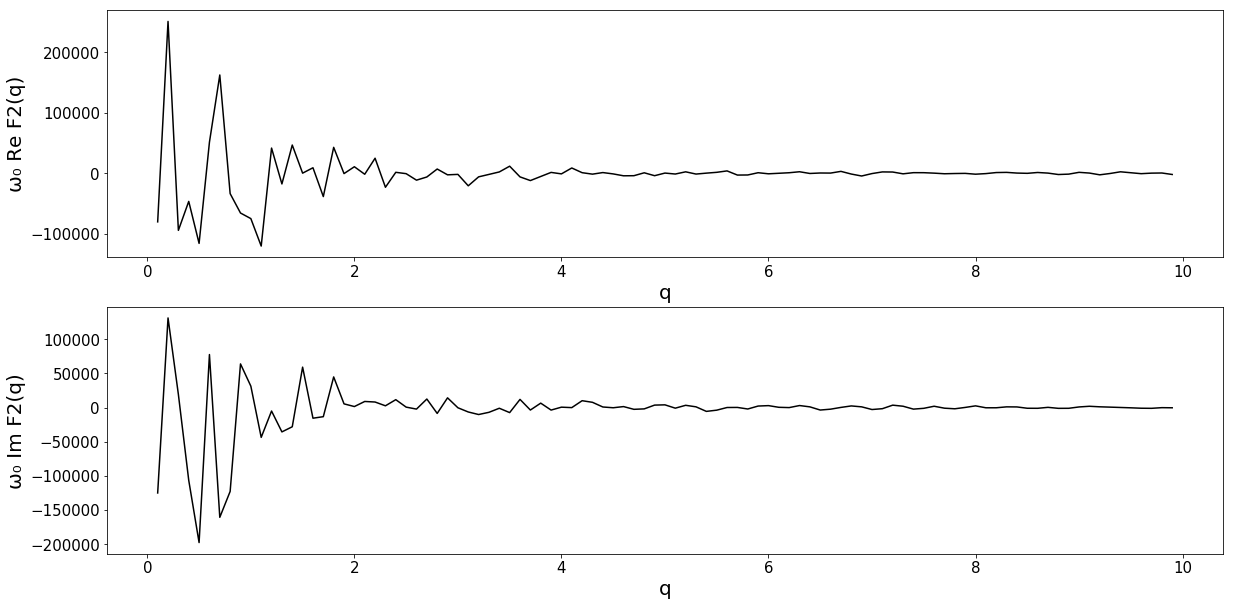

In [52]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

ax.set_ylabel('\u03C9\u2080 Re F2(q)', fontsize = 20)
ax.set_xlabel('q', fontsize = 20)
ax.plot(np.arange(0.1,10,0.1), ReF2, 'k')
ax.tick_params(axis='both', which='major', labelsize=15)


ax2.set_ylabel('\u03C9\u2080 Im F2(q)', fontsize = 20)
ax2.set_xlabel('q', fontsize = 20)
ax2.plot(np.arange(0.1,10,0.1), ImF2, 'k')
ax2.tick_params(axis='both', which='major', labelsize=15)

## Functions

In [15]:
# deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M, dTau):
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    
    return deltaT

# Tturb adds up the delta T's
def funTturb(deltaT):
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    Tturb.pop(-1)
    return Tturb

# generating F2, G1
def funF_k(std, limit, deltaT, Tturb):
    F_k =[]
    y1 = 0
    time = []
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], deltaT[i] / dTau):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                time.append(j + Tturb[i])
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k, time

In [17]:
def Funplots(t, f2):

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()